In [2]:
save_figures = True

In [3]:
from auxiliary_code.twitter_api_request import request_tweets
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

#### Number of tweets made
This process takes around 25 minutes

In [7]:
country = 'SO'
start_time = "2010-01-01T00:00:00.000Z"
end_time = "2022-06-01T00:00:00.000Z"
counts_en, _, _ = request_tweets(
    '', country, 'en', start_time, end_time, False, number_of_tweets=True)

counts_ar, _, _ = request_tweets(
    '', country, 'ar', start_time, end_time, False, number_of_tweets=True)

counts_tot, _, _ = request_tweets(
    '', country, '', start_time, end_time, False, number_of_tweets=True)

In [38]:
df = pd.DataFrame(counts_en + counts_ar + counts_tot).drop(['start'], axis=1).rename({'end': 'date'}, axis=1)
df['language'] = ['en'] * len(counts_en) + ['ar'] * len(counts_ar) + ['tot'] * len(counts_tot)
df['date'] = pd.to_datetime(df['date']).dt.tz_localize(None)

df = df.pivot(index='date', columns='language', values='tweet_count').reset_index()
df['other'] = df['tot'] - df[['ar', 'en']].sum(axis=1)
df.drop(['tot'], axis=1, inplace=True)

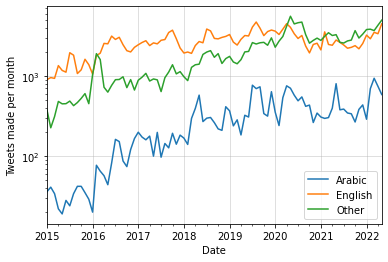

In [58]:
fig, ax = plt.subplots()
df[df['date'] >= pd.to_datetime('2015')].groupby(pd.Grouper(key='date', freq='1M')).sum()[:-1].plot(ax=ax)
ax.set_yscale('log')
ax.legend(['Arabic', 'English', 'Other'])
ax.set_xlabel('Date')
ax.set_ylabel('Tweets made per month')
ax.grid(zorder=0, alpha=0.5);

if save_figures:
    fig.savefig('../figures/number_of_tweets_by_language.pdf', format='pdf')

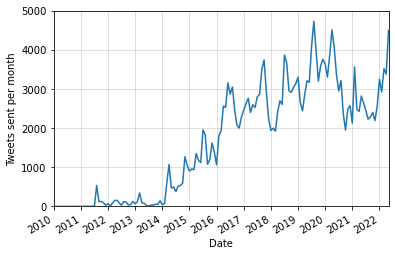

In [65]:
fig, ax = plt.subplots()
df.groupby(pd.Grouper(key='date', freq='1M')).sum()[:-1].plot(y='en', ax=ax, legend=False)
dates = pd.date_range('2010', '2022', freq=pd.DateOffset(years=1))
ax.xaxis.set_ticks(dates)
ax.xaxis.set_ticklabels(dates.strftime('%Y'))
plt.gcf().autofmt_xdate()
ax.set_xlabel('Date')
ax.set_ylabel('Tweets sent per month')
ax.set_ylim(0, 5000)
ax.grid(zorder=0, alpha=0.5);

if save_figures:
    fig.savefig('../figures/number_of_english_tweets.pdf', format='pdf')

In [62]:
df.to_csv('../datasets/twitter/number_of_tweets.csv', index=False)

### Obtaining the tweets

This process takes several hours. If one wants to obtain the tweet dataset,
it is adviced to run this process in batches (i.e. obtain all tweets for each year seperately) to minimize the chance of data loss

In [4]:
country = 'SO'
start_time = "2022-05-20T00:00:00.000Z"
end_time = "2022-06-01T00:00:00.000Z"
tweets, places, authors = request_tweets(
    '', country, 'en', start_time, end_time, False)

In [8]:
get_center = lambda bbox: [(bbox[0]+bbox[2])/2, (bbox[1] + bbox[3])/2]
place_df = []
for place in places:
            place_df.append(get_center(place['geo']['bbox']) + [place['id']])

place_df = pd.DataFrame(place_df).drop_duplicates()
place_df.columns = ['long', 'lat', 'place_id']

In [43]:
author_df = []
for author in authors:
            author_df.append([author['id'], author['description'], author['username'], author['name'], author['created_at']])

author_df = pd.DataFrame(author_df).drop_duplicates()
author_df.columns = ['author_id', 'description', 'username', 'name', 'created_at']
author_df['created_at'] = pd.to_datetime(author_df['created_at']).dt.tz_localize(None)

In [2]:
tweet_df = []
for tweet in tweets:
    if 'geo' not in tweet:
        tweet['geo'] = {'place_id': None}
    tweet_df.append([tweet['text'], tweet['author_id'], tweet['geo']['place_id'], tweet['public_metrics']['like_count'],  tweet['public_metrics']['reply_count'], tweet['created_at'], tweet['id'], tweet['source']])

cols = ['text', 'author_id', 'place_id', 'likes', 'replies', 'date', 'id', 'source']

tweet_df = pd.DataFrame(tweet_df, columns=cols)
tweet_df = tweet_df.merge(place_df, left_on='place_id', right_on='place_id')
tweet_df = tweet_df.merge(author_df, left_on='author_id', right_on='author_id')

In [73]:
tweet_df.to_csv('../datasets/twitter/tweets.csv', index=False)